In [165]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import invgauss, expon, genexpon, genextreme
from scipy.stats import kstest, norm, chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from numpy import mean, std
from collections import Counter
from sklearn import metrics
from sklearn.feature_selection import chi2, RFE
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from collections import Counter
from sklearn.pipeline import Pipeline

In [189]:
# Read in data, view data shape and data types
df = pd.read_csv('')
df.head()
# Shape of data
df.shape
# Check data types
# df.info(verbose=True)

(52, 133)

In [86]:
# Remove columns patient Id and the binary columns of diagnosis
df.drop(['patient_id', 'C', 'B', 'A', 'control'], axis=1, inplace=True)

In [87]:
# Check for missing values
df.loc[:, df.isnull().any()].columns
df[["MF74", "MF6"]].isna().sum()

MF74    5
MF6     2
dtype: int64

/Users/rc101/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


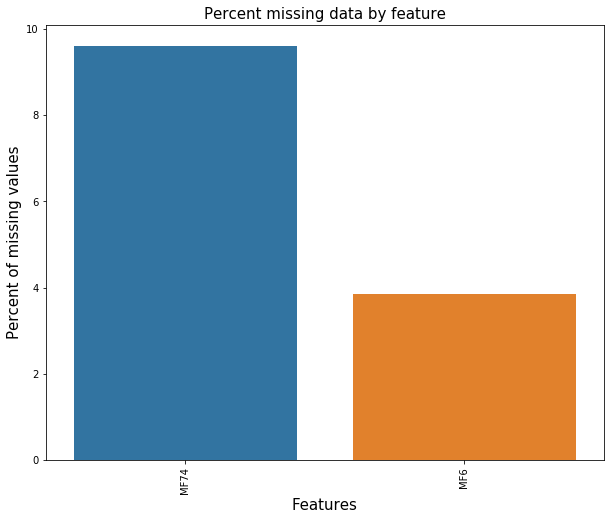

In [88]:
# Find the ratio of missing data by column
df_na = (df.isnull().sum()/len(df))*100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})

f, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation='90')
sns.barplot(df_na.index, y=df_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

In [89]:
# To deal with missing data due to left censoring use the 'fill-in method':
# - Find underlying distribution of data
# - Find parameters of best fit
# - Randomly sample values from the left of the distribution

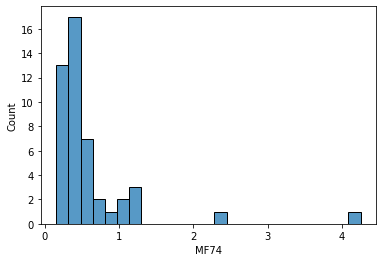

In [90]:
# Histogram plot of MF74 - maybe inverse gaussian distribution?
MF74 = df["MF74"].dropna()
graph = sns.histplot(data=MF74)

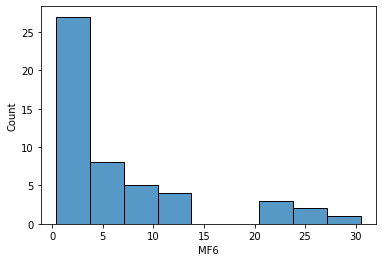

In [91]:
# Histogram plot of MF6 - looks like more of an exponential distribution
MF6 = df["MF6"].dropna()
sns.histplot(data=MF6)

In [63]:
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme", "invgauss", "expon"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]
get_best_distribution(MF74)

p value for norm = 0.001380562457749771
p value for exponweib = 0.9836630530060622
p value for weibull_max = 0.10727779052690198
p value for weibull_min = 0.36067446362245953
p value for pareto = 0.12839689800742118
p value for genextreme = 0.9990165518472922
p value for invgauss = 0.690838945614366
p value for expon = 0.22014406397851086
Best fitting distribution: genextreme
Best p value: 0.9990165518472922
Parameters for the best fit: (-0.5059244157082472, 0.34051518442141704, 0.16606990695188772)


/Users/rc101/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


('genextreme',
 0.9990165518472922,
 (-0.5059244157082472, 0.34051518442141704, 0.16606990695188772))

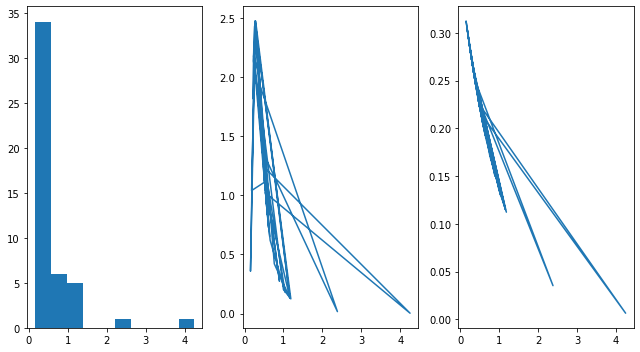

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))# Histogram Plot of Observed Data
axes[0].hist(MF74)#Exponential Distribution Fitting
axes[1].plot(MF74,genextreme.pdf(MF74,-0.5059244157082472, 0.34051518442141704, 0.16606990695188772))#Inverse-Gaussian Distribution Fitting
axes[2].plot(MF74,invgauss.pdf(MF74,0.45, -1.64, 3.61))
fig.tight_layout()

In [92]:
# Create a random list of variables from distribution which are between 0 and the lowest value of MF74 and subsitute
arr = genextreme.rvs(0.45, -1.64, 3.61, size=1000)

filter_arr = []

# go through each element in arr
for element in arr:
  # if the element is higher than 42, set the value to True, otherwise False:
  if 0 < element <0.15:
    filter_arr.append(True)
  else:
    filter_arr.append(False)

newarr = arr[filter_arr]

filler = [0.12794774,0.11834351,0.01855698,0.03189033,0.07603456]
df.loc[df.MF74.isnull(), 'MF74'] = filler

In [66]:
# Find best underlying distribution for MF6
get_best_distribution(MF6)

p value for norm = 0.009473119581559797
p value for exponweib = 0.19067767222058488
p value for weibull_max = 7.126375187088336e-31
p value for weibull_min = 0.9004551383482816
p value for pareto = 0.1742192438124427

/Users/rc101/anaconda/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:1469: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))



p value for genextreme = 0.9556849727602649
p value for invgauss = 0.9272272565670259
p value for expon = 0.10533479063907526
Best fitting distribution: genextreme
Best p value: 0.9556849727602649
Parameters for the best fit: (-0.828896720054136, 2.2121243264741475, 2.2694610426665496)


('genextreme',
 0.9556849727602649,
 (-0.828896720054136, 2.2121243264741475, 2.2694610426665496))

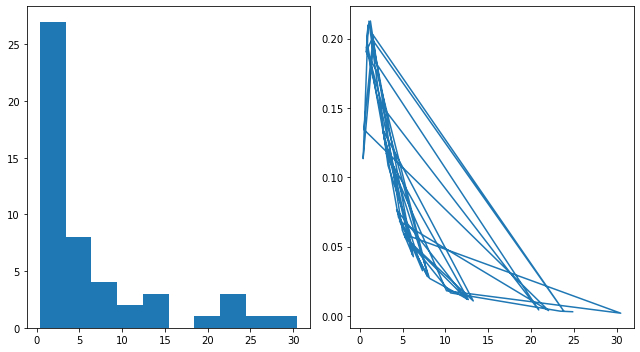

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))# Histogram Plot of Observed Data
axes[0].hist(MF6)
axes[1].plot(MF6,genextreme.pdf(MF6,-0.828896720054136, 2.2121243264741475, 2.2694610426665496))
fig.tight_layout()

In [93]:
# Substitute in values
arr_MF6 = genextreme.rvs(-0.828896720054136, 2.2121243264741475, 2.2694610426665496, size=1000)

filter_arr_MF6 = []

# go through each element in arr
for element in arr_MF6:
  # if the element is higher than 42, set the value to True, otherwise False:
  if 0 < element <0.38:
    filter_arr_MF6.append(True)
  else:
    filter_arr_MF6.append(False)

newarr = arr_MF6[filter_arr_MF6]
filler = [0.30918898,0.36274984]
df.loc[df.MF6.isnull(), 'MF6'] = filler

In [69]:
# Check for duplicated rows
df.duplicated().any()

False

In [70]:
# To decide whether to use parametric or non-parametric tests, check whether any variables have a Gaussian distribution
table=[]
for column in df.iloc[:, 0:122]:
    table.append(kstest(df[column], 'norm'))
cols=['ks statistic', 'p value']
result = pd.DataFrame(table, columns=cols)


# Are there any p-values larger than 0.05?
(result['p value']>0.05).any()

False

In [71]:
# Look at molecular feature abundances for the different disease groups

In [94]:
LE = LabelEncoder()
df['diagnosis'] = LE.fit_transform(df['diagnosis'])
disease_group_a = df[df['diagnosis']==0]
disease_group_b = df[df['diagnosis']==1]
disease_group_control = df[df['diagnosis']==3]
disease_group_c = df[df['diagnosis']==2]
disease_group_a=disease_group_a.select_dtypes(include=['float64'])
disease_group_b=disease_group_b.select_dtypes(include=['float64'])
disease_group_c=disease_group_c.select_dtypes(include=['float64'])
disease_group_control=disease_group_control.select_dtypes(include=['float64'])

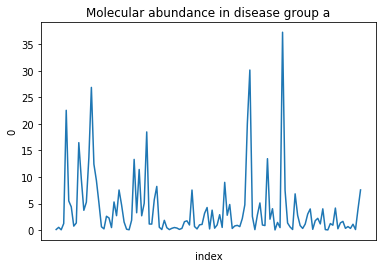

In [73]:
# For disease group a
disease_group_a_average = disease_group_a.mean(axis=0)
axes = disease_group_a_average.axes[0].values
values = disease_group_a_average.values
disease_group_a_average=pd.DataFrame([values], columns=axes)
# Find the smallest level of each molecule that was present for B
minimum_molecular_values_a = disease_group_a.apply(lambda x: x.sort_values().unique()[0], axis=0)
disease_group_a_average = disease_group_a_average.append(minimum_molecular_values_a, ignore_index=True)
# Find the largest level of each molecule that was present for B
maximum_molecular_values_a = disease_group_a.max()
disease_group_a_average = disease_group_a_average.append(maximum_molecular_values_a, ignore_index=True)
# Wrangle dataframe into correct form to create graph
disease_group_a_average=disease_group_a_average.T
disease_group_a_average.reset_index(inplace=True)
graph_average_a=sns.lineplot(data=disease_group_a_average, x="index", y=0)
graph_average_a.set(title='Molecular abundance in disease group a')
graph_average_a.set(xticklabels=[])
graph_average_a.tick_params(bottom=False)

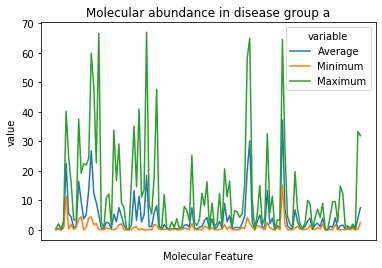

In [74]:
disease_group_a_average=disease_group_a_average.rename(columns = {'index':'Molecular Feature', 0:'Average', 1:'Minimum', 2:'Maximum'})
disease_group_a_graph=sns.lineplot(x='Molecular Feature', y='value', hue='variable', 
             data=pd.melt(disease_group_a_average, ['Molecular Feature']))
disease_group_a_graph.set(title='Molecular abundance in disease group a')
disease_group_a_graph.set(xticklabels=[])
disease_group_a_graph.tick_params(bottom=False)

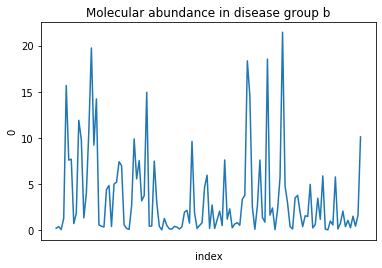

In [75]:
# For disease group b
disease_group_b_average = disease_group_b.mean(axis=0)
axes = disease_group_b_average.axes[0].values
values = disease_group_b_average.values
disease_group_b_average=pd.DataFrame([values], columns=axes)
# Find the smallest level of each molecule that was present for B
minimum_molecular_values_b = disease_group_b.apply(lambda x: x.sort_values().unique()[0], axis=0)
disease_group_b_average = disease_group_b_average.append(minimum_molecular_values_b, ignore_index=True)
# Find the largest level of each molecule that was present for B
maximum_molecular_values_b = disease_group_b.max()
disease_group_b_average = disease_group_b_average.append(maximum_molecular_values_b, ignore_index=True)
# Wrangle dataframe into correct form to create graph
disease_group_b_average=disease_group_b_average.T
disease_group_b_average.reset_index(inplace=True)
graph_average_b=sns.lineplot(data=disease_group_b_average, x="index", y=0)
graph_average_b.set(title='Molecular abundance in disease group b')
graph_average_b.set(xticklabels=[])
graph_average_b.tick_params(bottom=False)

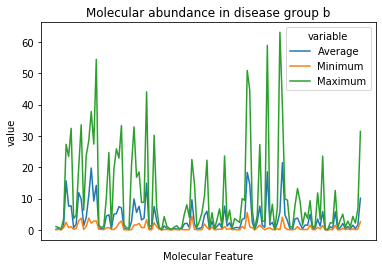

In [76]:
disease_group_b_average=disease_group_b_average.rename(columns = {'index':'Molecular Feature', 0:'Average', 1:'Minimum', 2:'Maximum'})
disease_group_b_graph=sns.lineplot(x='Molecular Feature', y='value', hue='variable', 
             data=pd.melt(disease_group_b_average, ['Molecular Feature']))
disease_group_b_graph.set(title='Molecular abundance in disease group b')
disease_group_b_graph.set(xticklabels=[])
disease_group_b_graph.tick_params(bottom=False)

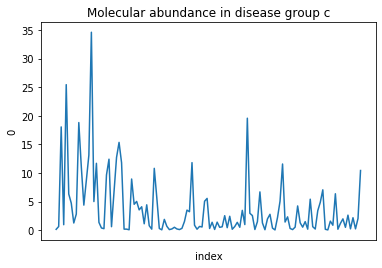

In [77]:
# For disease group c
disease_group_c_average = disease_group_c.mean(axis=0)
axes = disease_group_c_average.axes[0].values
values = disease_group_c_average.values
disease_group_c_average=pd.DataFrame([values], columns=axes)
# Find the smallest level of each molecule that was present for B
minimum_molecular_values_c = disease_group_c.apply(lambda x: x.sort_values().unique()[0], axis=0)
disease_group_c_average = disease_group_c_average.append(minimum_molecular_values_c, ignore_index=True)
# Find the largest level of each molecule that was present for B
maximum_molecular_values_c = disease_group_c.max()
disease_group_c_average = disease_group_c_average.append(maximum_molecular_values_c, ignore_index=True)
# Wrangle dataframe into correct form to create graph
disease_group_c_average=disease_group_c_average.T
disease_group_c_average.reset_index(inplace=True)
graph_average_c=sns.lineplot(data=disease_group_c_average, x="index", y=0)
graph_average_c.set(title='Molecular abundance in disease group c')
graph_average_c.set(xticklabels=[])
graph_average_c.tick_params(bottom=False)

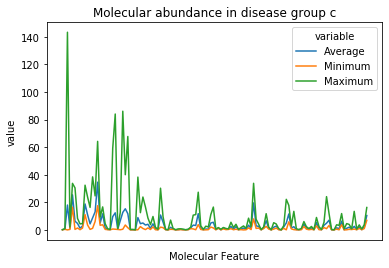

In [78]:
disease_group_c_average=disease_group_c_average.rename(columns = {'index':'Molecular Feature', 0:'Average', 1:'Minimum', 2:'Maximum'})
disease_group_c_graph=sns.lineplot(x='Molecular Feature', y='value', hue='variable', 
             data=pd.melt(disease_group_c_average, ['Molecular Feature']))
disease_group_c_graph.set(title='Molecular abundance in disease group c')
disease_group_c_graph.set(xticklabels=[])
disease_group_c_graph.tick_params(bottom=False)

In [79]:
# As there isn't univariate normality of variables, check correlation between continuous variables with spearman
spearman_df=df.select_dtypes(include=['float64'])
correlation_matrix=spearman_df.corr(method="spearman")
# Wrangle matrix to get in more readable format and look at variables that have very high correlation with each other
# (i.e. 80% and higher)
ordered_correlation_matrix = correlation_matrix.abs().unstack().reset_index()
ordered_correlation_matrix = ordered_correlation_matrix[ordered_correlation_matrix['level_0'] != ordered_correlation_matrix['level_1']]
ordered_correlation_matrix=ordered_correlation_matrix.rename(columns={0: "correlation_value"})
cols = ['correlation_value']
ordered_correlation_matrix[cols] = ordered_correlation_matrix[ordered_correlation_matrix[cols] > 0.8][cols]
ordered_correlation_matrix=ordered_correlation_matrix.dropna()
ordered_correlation_matrix = ordered_correlation_matrix[~pd.DataFrame(np.sort(ordered_correlation_matrix[['level_0','level_1']], axis=1), index=ordered_correlation_matrix.index).duplicated()]
print(ordered_correlation_matrix)

      level_0 level_1  correlation_value
1111     MF10    MF14           0.804918
1112     MF10    MF15           0.899428
1971     MF17    MF20           0.941774
1981     MF17    MF30           0.972082
1997     MF17    MF46           0.857509
2058     MF17   MF107           0.832152
2347     MF20    MF30           0.927431
2363     MF20    MF46           0.825322
2586     MF22    MF25           0.990011
2594     MF22    MF33           0.834970
2840     MF24    MF35           0.889866
2878     MF24    MF73           0.988816
2960     MF25    MF33           0.815675
3583     MF30    MF46           0.862717
3644     MF30   MF107           0.822334
4061     MF34    MF36           0.903867
4062     MF34    MF37           0.810638
4220     MF35    MF73           0.875438
4263     MF35   MF116           0.825664
4306     MF36    MF37           0.921284
4812     MF40    MF55           0.817297
5432     MF45    MF65           0.900026
5466     MF45    MF99           0.807735
5474     MF45   

In [80]:
# Check relationships between the categorical variables using the chi-squared test
# Expect strong relationship between variables smoker and current smoker
chi_smoking = pd.crosstab(df.smoker, df.current_smoker, margins=True)
value = np.array([chi_smoking.iloc[0][0:3].values,
                  chi_smoking.iloc[1][0:3].values])

print(chi2_contingency(value)[0:3])
# As the p-value is less than 0.05, we reject the Null hypothesis and assume the variables are dependent on each other

(6.975023126734505, 0.030576866172772863, 2)


In [81]:
# Is there a relationship between smoking and alcohol use?
chi_alcohol = pd.crosstab(df.smoker, df.alcohol_use, margins=True)
value = np.array([chi_alcohol.iloc[0][0:3].values,
                  chi_alcohol.iloc[1][0:3].values])

print(chi2_contingency(value)[0:3])

(2.6226086956521746, 0.26946834660651336, 2)


In [82]:
# Is there a relationship between smoking and gender or alcohol and gender?
chi_gender = pd.crosstab(df.smoker, df.sex, margins=True)
value = np.array([chi_gender.iloc[0][0:3].values,
                  chi_gender.iloc[1][0:3].values])
print(chi2_contingency(value)[0:3])

chi_gender = pd.crosstab(df.alcohol_use, df.sex, margins=True)
value = np.array([chi_gender.iloc[0][0:3].values,
                  chi_gender.iloc[1][0:3].values])
print(chi2_contingency(value)[0:3])

(0.3714613281594498, 0.8304972476022074, 2)
(1.1011764705882354, 0.5766105279378233, 2)


In [183]:
# Set up the feature matrix and the target variable
y=df['diagnosis'].to_numpy()
# Drop smoker because this has high correlation with current smoker
X=df.drop(['diagnosis', 'smoker', 'MF89'], axis=1) 

In [184]:
# Standardise the data in the features matrix
X=StandardScaler(with_mean=0, with_std=1).fit_transform(X)

In [185]:
# Look at the number of events are present for each disease group
print(Counter(y))

Counter({3: 17, 0: 15, 1: 12, 2: 8})


In [186]:
# Create a multinomial logistic regression model
# Use grid search to find best parameters
param_grid_lr = {
    'multi_class' : ['multinomial'],
    'max_iter': [20, 50, 100, 200, 500, 1000,2000,5000],                      
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],   
    'class_weight': ['balanced']                                    
}
logModel_grid = GridSearchCV(estimator=LogisticRegression(random_state=1234), param_grid=param_grid_lr, verbose=1, cv=8, n_jobs=-1)
logModel_grid.fit(X, y)
print(logModel_grid.best_estimator_)

Fitting 8 folds for each of 32 candidates, totalling 256 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=1234, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:    3.5s finished
/Users/rc101/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [187]:
# Instantiate the model
model=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=20, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=1234, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [188]:
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.605 (0.186)


In [159]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

#fit the model using the training data
model.fit(X_train,y_train)

#use model to make predictions on test data
y_pred = model.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.75


/Users/rc101/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [ ]:
# Next steps: eliminate more features - maybe with RFE package in sklearn?
# As rule of thumb want number of features to be sqrt of number of observations